## Problem statement

The goal is to design a machine learning algorithm that can automatically identify hand drawn images as well as reason about their appearance. The dataset we have prepared is a variant of google’s quick draw dataset. For that dataset, a popular goal has been to simply classify the given human drawn images. There are 31 classes (pencil, rabbit, rollerskates,...)

![title](img/intro.jpg)

## Preprocess data - get rid of the noises using openCV

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import csv

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("/input"))

#Load images with numpy
images = np.load('input/train_images.npy',encoding='latin1')
imagesTest = np.load('input/test_images.npy',encoding='latin1')

In [7]:
# make dict {0:"sink",1:"pear",...} 
categories=["sink","pear","moustache","nose","skateboard","penguin","peanut","skull","panda","paintbrush","nail","apple","rifle","mug","sailboat","pineapple","spoon","rabbit","shovel","rollerskates","screwdriver","scorpion","rhinoceros","pool","octagon","pillow","parrot","squiggle","mouth","empty","pencil"]
categories_dict = dict(enumerate(categories))
print(categories_dict)

{0: 'sink', 1: 'pear', 2: 'moustache', 3: 'nose', 4: 'skateboard', 5: 'penguin', 6: 'peanut', 7: 'skull', 8: 'panda', 9: 'paintbrush', 10: 'nail', 11: 'apple', 12: 'rifle', 13: 'mug', 14: 'sailboat', 15: 'pineapple', 16: 'spoon', 17: 'rabbit', 18: 'shovel', 19: 'rollerskates', 20: 'screwdriver', 21: 'scorpion', 22: 'rhinoceros', 23: 'pool', 24: 'octagon', 25: 'pillow', 26: 'parrot', 27: 'squiggle', 28: 'mouth', 29: 'empty', 30: 'pencil'}


## Find the dimensions of the largest contour (width and height)

In [57]:
# Find maxWidth & maxHeight of the largest contour
# Later on we reduce all the images to this (maxWidth x maxHeight)
# We already ran this code and found (maxWidth, maxHeight) = (38,38)
# So no need to run this code again since it would take a while

def find_largest_contour():
    maxHeight = 0
    maxWidth = 0
    for i in range(10000):
        image = (images[i][1]).reshape(100,100)
        testImage = (imagesTest[i][1]).reshape(100,100)

        f_image = np.uint8(image)
        f_testImage = np.uint8(testImage)

        ret, thresh = cv2.threshold(f_image, 127, 255, 0)
        testRet, testThresh = cv2.threshold(f_testImage, 127,255,0)

        f_image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        f_testImage, testContours, testHierarchy = cv2.findContours(testThresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            c = max(contours, key=cv2.contourArea)
            _,_,w,h = cv2.boundingRect(c)
            height = h
            width = w
            #print(w,h)
            if height > maxHeight:
                maxHeight = height
            if width > maxWidth:
                maxWidth = width
        if len(testContours) > 0:
            c = max(testContours, key=cv2.contourArea)
            x,y,w,h = cv2.boundingRect(c)
            height = h
            width = w
            if height > maxHeight:
                maxHeight = height
            if width > maxWidth:
                maxWidth = width


    print(maxHeight)
    print(maxWidth)
    return (maxHeight,maxWidth)
    #this returns (38,38)


In [18]:
# maxHeight,maxWidth = find_largest_contour() = (38,38)
# Every image will be reduce to this size
maxHeight = 38 
maxWidth = 38 

## Preprocess train and test images 

In [16]:
#Fix images (remove noises + center + crop)
#No need to run this code again since we're already outputted xTrain.npy, yTrain.npy and xTest.npy
images_fixed = []
test_images_fixed = []


for i in range(10000):
    #Train images
    image = (images[i][1]).reshape(100,100)
    f_image = np.uint8(image)
    f_image, contours, hierarchy = cv2.findContours(f_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Test images
    testImage = (imagesTest[i][1]).reshape(100,100)
    f_testImage = np.uint8(testImage)
    f_testImage, testContours, testHierarchy = cv2.findContours(f_testImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
            # Find 2 max contours based on (1) Area and (2) Perimiter
            c = max(contours, key=cv2.contourArea)
            c2 = max(contours, key=lambda x: cv2.arcLength(x, True))
          
            #Find the bounding area of each contour
            _,_,w,h = cv2.boundingRect(c)
            _,_,w2,h2 = cv2.boundingRect(c2)
            
            #Compare the 2 areas
            if(w*h >= w2*h2): 
                f_image = cv2.drawContours(np.zeros(image.shape), [c], 0, 1, -1)
            else:
                f_image = cv2.drawContours(np.zeros(image.shape), [c2], 0, 1, -1)
            # The main shape will be the one with largest bounding area
            finalShape = image*f_image
            
            #Move object to Center
            M = cv2.moments(finalShape)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            rows,cols = finalShape.shape
            M = np.float32([[1,0,50-center[0]],[0,1,50-center[1]]])
            finalShape = cv2.warpAffine(finalShape,M,(cols,rows))
            
            #Crop down to 38x38
            y1 = int(50-float(maxHeight)/2)
            y2 = int(50+float(maxHeight)/2)
            x1 = int(50-float(maxWidth)/2)
            x2 = int(50+float(maxWidth)/2)
            finalShape = finalShape[y1:y2,x1:x2]
            #print(finalShape.shape)
            
            #normalize pixels from (0-255) to (0-1)
            for i in range(maxHeight):
                for j in range(maxWidth):
                        finalShape[i][j] = float(finalShape[i][j]/255)           
    
            finalShape = finalShape.reshape(maxWidth*maxHeight)
            images_fixed.append(finalShape)
            
    if len(testContours) > 0:
            # Find 2 max contours based on (1) Area and (2) Perimiter
            c = max(testContours, key=cv2.contourArea)
            c2 = max(testContours, key=lambda x: cv2.arcLength(x, True))
            
            #Find the bounding area of each contour
            _,_,w,h = cv2.boundingRect(c)
            _,_,w2,h2 = cv2.boundingRect(c2)
            
            #Compare the 2 areas
            if(w*h >= w2*h2): 
                f_testImage = cv2.drawContours(np.zeros(testImage.shape), [c], 0, 1, -1)
            else:
                f_testImage = cv2.drawContours(np.zeros(testImage.shape), [c2], 0, 1, -1)
            
            # The main shape will be the one with largest bounding area
            testFinalShape = testImage*f_testImage
            
            #Move object to Center
            M = cv2.moments(testFinalShape)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            rows,cols = testFinalShape.shape
            M = np.float32([[1,0,50-center[0]],[0,1,50-center[1]]])
            testFinalShape = cv2.warpAffine(testFinalShape,M,(cols,rows))
            
            #Crop down to 38x38
            y1 = int(50-float(maxHeight)/2)
            y2 = int(50+float(maxHeight)/2)
            x1 = int(50-float(maxWidth)/2)
            x2 = int(50+float(maxWidth)/2)
            testFinalShape = testFinalShape[y1:y2,x1:x2]
            
            # Normalize pixels from (0-255) to (0-1)
            for i in range(maxHeight):
                for j in range(maxWidth):
                    testFinalShape[i][j] = float(testFinalShape[i][j]/255)
            testFinalShape = testFinalShape.reshape(maxWidth*maxHeight)
            test_images_fixed.append(testFinalShape)

## Pictures after preprocessing: 

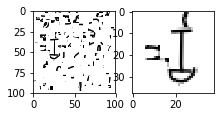

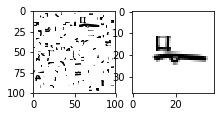

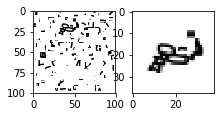

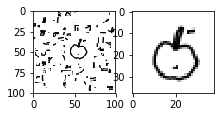

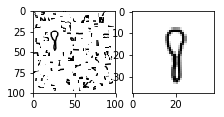

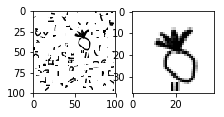

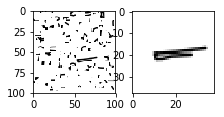

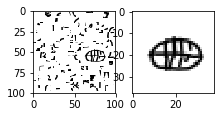

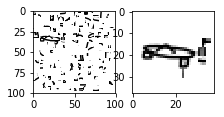

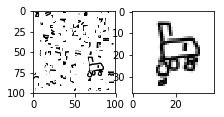

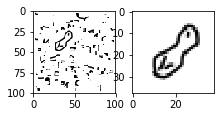

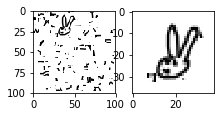

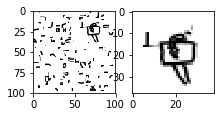

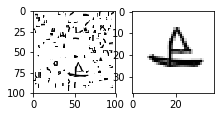

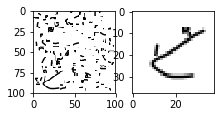

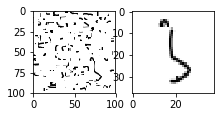

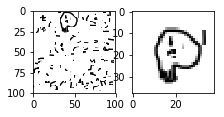

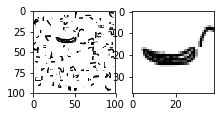

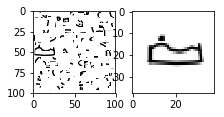

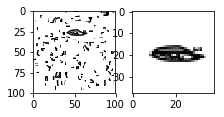

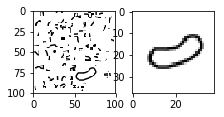

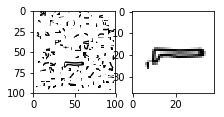

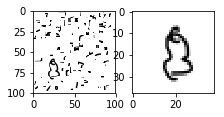

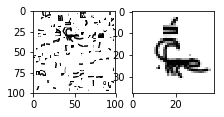

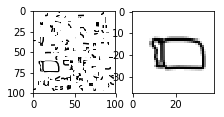

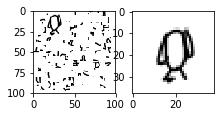

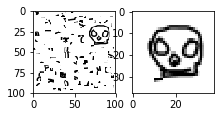

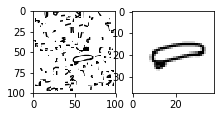

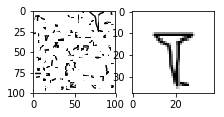

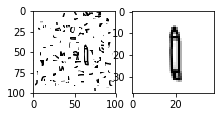

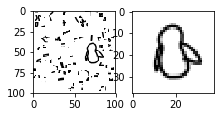

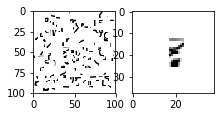

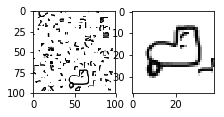

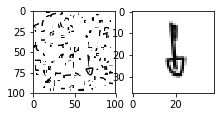

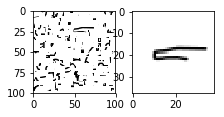

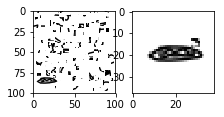

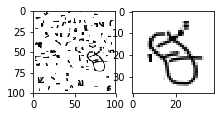

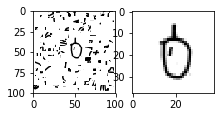

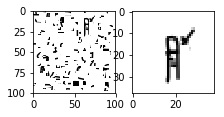

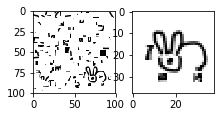

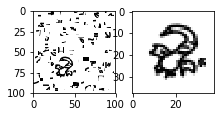

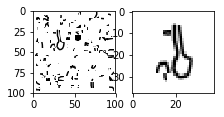

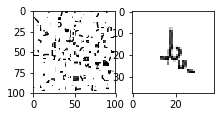

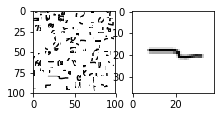

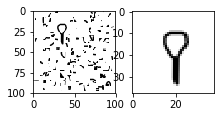

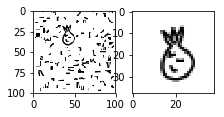

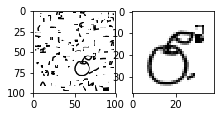

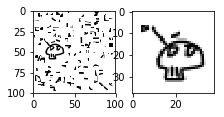

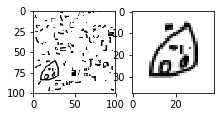

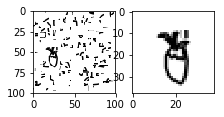

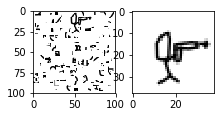

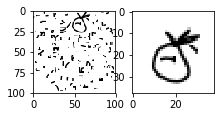

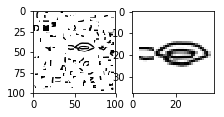

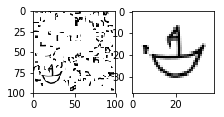

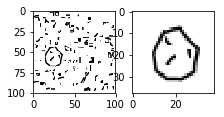

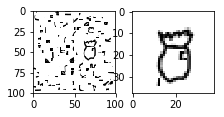

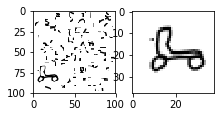

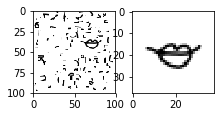

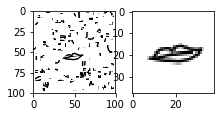

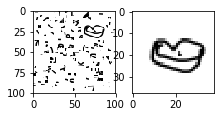

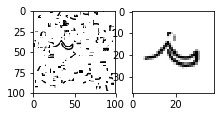

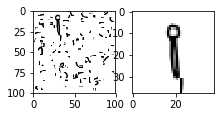

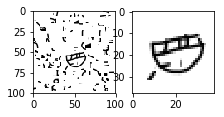

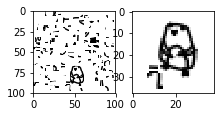

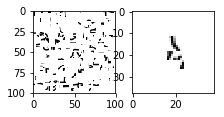

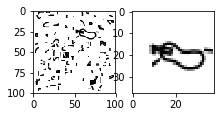

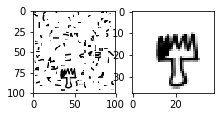

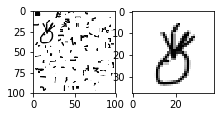

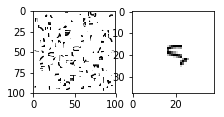

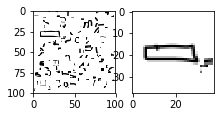

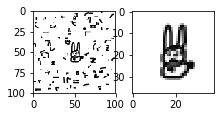

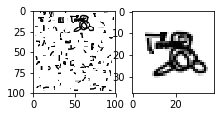

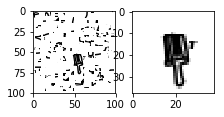

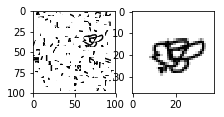

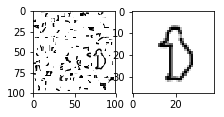

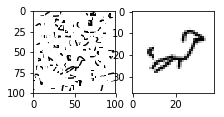

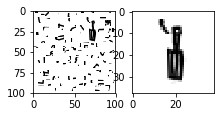

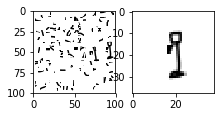

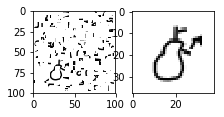

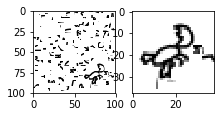

In [35]:
#Examples of cleaned images:
for i in range(0,80):
    #image = image.reshape(maxHeight,maxWidth)
    plt.figure(figsize=(5,5))
    plt.subplot(131)
    plt.imshow(images[i][1].reshape(100,100),cmap = plt.cm.binary)
    plt.subplot(132)
    plt.imshow(xTrain[i].reshape(38,38),cmap = plt.cm.binary)
    plt.show()

## Ouput xTrain.npy, xTest.npy and yTrain.npy

In [17]:
#output xTrain.npy
xTrain = np.array(images_fixed)
np.save('xTrain', xTrain)

In [19]:
#output xTest.npy
xTest = np.array(test_images_fixed)
np.save('xTest', xTest)

In [20]:
# ouput yTrain.npy
train_labels = []
with open("input/train_labels.csv") as file:
    reader = csv.reader(file)
    for line in reader:
        train_labels.append(line[1])
train_labels.pop(0)

#train_labels_list to numLabels
#['sink','moustache',...] = > [0,2,...]
temp_dict = dict(zip(categories,range(len(categories))))
numLabels = [temp_dict[label] for label in train_labels]             
y_train = np.array(numLabels).reshape(10000,1)
print("y_train: \n", y_train)

np.save('yTrain', y_train)

y_train: 
 [[18]
 [12]
 [21]
 ...
 [19]
 [28]
 [30]]
